In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')
import pickle 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
import string
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
vectorizer=TfidfVectorizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df=pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None, names=['label', 'message'])
df.columns=['label', 'message']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [3]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df.sample(5)

,label,message,label_num
2602,ham,Okie,0
1930,spam,Free 1st week entry 2 TEXTPOD 4 a chance 2 win...,1
1523,ham,I thk u dun haf 2 hint in e forum already lor....,0
4054,ham,I was slept that time.you there?,0
221,ham,Ok no prob. Take ur time.,0


In [4]:
df['label_num'].value_counts()

label_num
0    4825
1     747
Name: count, dtype: int64

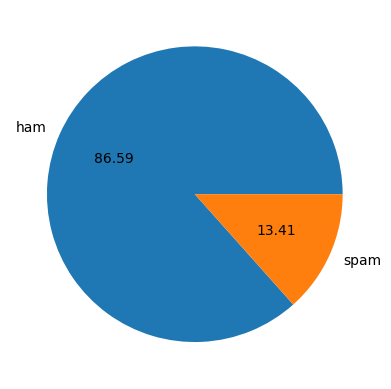

In [5]:
plt.pie(df['label_num'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [6]:
df['length']=df['message'].apply(len)
df['num_words']=df['message'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sent']=df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [7]:
df.head()

,label,message,label_num,length,num_words,num_sent
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,ham,Ok lar... Joking wif u oni...,0,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2
3,ham,U dun say so early hor... U c already then say...,0,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1


In [8]:
df[['length','num_words','num_sent']].describe()

,length,num_words,num_sent
count,5572.000000,5572.000000,5572.000000
mean,80.490309,18.842426,2.006102
std,59.944527,13.851947,1.539977
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,62.000000,15.000000,2.000000
75%,122.000000,27.000000,3.000000
max,910.000000,220.000000,38.000000


In [9]:
df[df['label_num']==0][['length','num_words','num_sent']].describe()

,length,num_words,num_sent
count,4825.000000,4825.000000,4825.000000
mean,71.482902,17.425699,1.846010
std,58.442635,14.118631,1.475377
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,93.000000,23.000000,2.000000
max,910.000000,220.000000,38.000000


In [10]:
df[df['label_num']==1][['length','num_words','num_sent']].describe()

,length,num_words,num_sent
count,747.000000,747.000000,747.000000
mean,138.670683,27.993307,3.040161
std,28.873603,6.860440,1.548499
min,13.000000,2.000000,1.000000
25%,133.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


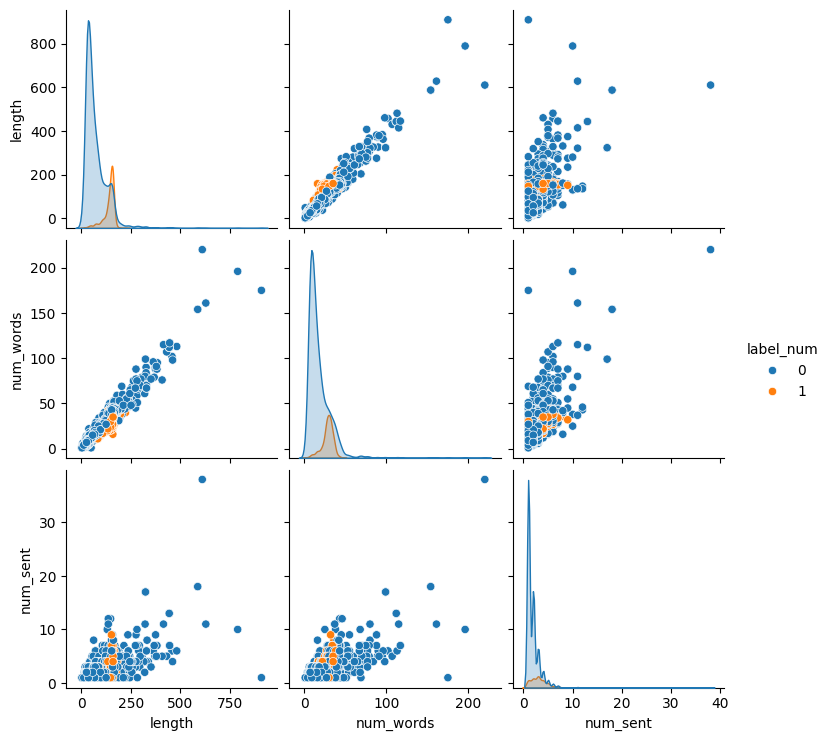

In [11]:
sns.pairplot(df,hue='label_num')

In [12]:
df.select_dtypes(include=['number']).corr()

,label_num,length,num_words,num_sent
label_num,1.000000,0.381925,0.259958,0.264230
length,0.381925,1.000000,0.966435,0.630628
num_words,0.259958,0.966435,1.000000,0.685898
num_sent,0.264230,0.630628,0.685898,1.000000


In [13]:
def transform_sms(text):
    text=text.lower()
    text=nltk.word_tokenize(text)
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)

In [14]:
df['transformed']=df['message'].apply(transform_sms)

In [15]:
df.head()

,label,message,label_num,length,num_words,num_sent,transformed
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,0,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think goe usf live around though


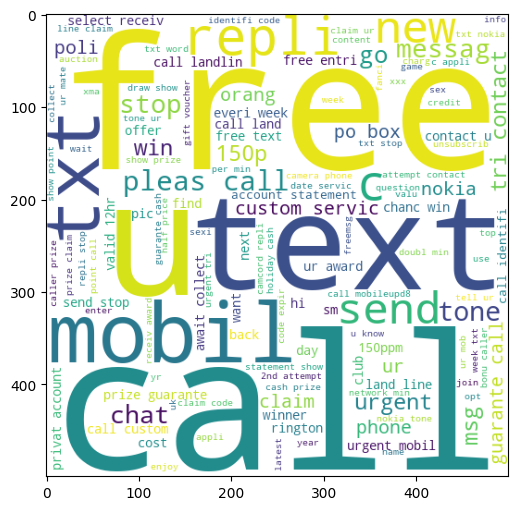

In [16]:
spam_wc=wc.generate(df[df['label_num']==1]['transformed'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

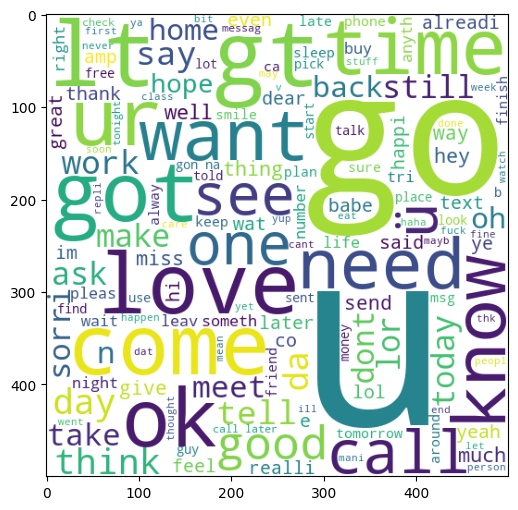

In [17]:
ham_wc=wc.generate(df[df['label_num']==0]['transformed'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [18]:
X=df['message']
y=df['label_num']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [19]:
vectorizer=TfidfVectorizer()
X_train_vectorized=vectorizer.fit_transform(X_train)

In [20]:
model=BernoulliNB()
model.fit(X_train_vectorized, y_train)
X_test_vectorized=vectorizer.transform(X_test)
y_pred=model.predict(X_test_vectorized)
print(confusion_matrix(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[[956   1]
 [ 31 127]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       957
           1       0.99      0.80      0.89       158

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [21]:
model=MultinomialNB()
model.fit(X_train_vectorized, y_train)
X_test_vectorized=vectorizer.transform(X_test)
y_pred=model.predict(X_test_vectorized)
print(confusion_matrix(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[[957   0]
 [ 53 105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       957
           1       1.00      0.66      0.80       158

    accuracy                           0.95      1115
   macro avg       0.97      0.83      0.89      1115
weighted avg       0.95      0.95      0.95      1115



In [22]:
with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [23]:
def predict_spam_ham(text_message):
    with open('vectorizer.pkl', 'rb') as vec_file:
        loaded_vectorizer = pickle.load(vec_file)
    with open('model.pkl', 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    input_vector = loaded_vectorizer.transform([text_message])  
    prediction = loaded_model.predict(input_vector)[0] 
    return "SPAM" if prediction == 1 else "HAM"

In [24]:
while True:
    user_input=input("Enter an SMS message (or type 'exit' to quit):\n")
    if user_input.lower() == 'exit':
        break
    prediction = predict_spam_ham(user_input)
    print("Prediction:", prediction)

Prediction: HAM
Prediction: HAM
Prediction: HAM
